# Eksploracja i analiza danych

## Questions/Answers over time

In [1]:
from pyspark.sql import (
    SparkSession,
    functions as f
    )
import matplotlib



In [2]:
#| output: false

spark = SparkSession.builder.master("local[12]").appName("Analytics").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/14 19:44:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
posts = spark.read.format('parquet').load("s3://preprocessed-data-beer-and-wine//posts")
posts.cache()

In [3]:
posts = spark.read.format('parquet').load("outputs/posts")
posts.show(1, vertical=True)

-RECORD 0----------------------------------------
 accepted_answer_id       | 4                    
 answer_count             | 1                    
 body                     | <p>I was offered ... 
 body_clean               | I was offered a b... 
 closed_date              | null                 
 comment_count            | 0                    
 community_owned_date     | null                 
 content_licence          | CC BY-SA 3.0         
 creation_date            | 2014-01-21 20:26:... 
 favourite_count          | null                 
 id                       | 1                    
 last_activity_date       | 2014-01-21 22:04:... 
 last_edit_date           | 2014-01-21 22:04:... 
 last_editor_display_name | null                 
 last_editor_user_id      | 8                    
 owner_user_id            | 7                    
 post_type_id             | 1                    
 parent_id                | null                 
 score                    | 21                   


In [4]:
posts_grouped = (
    posts
    .filter(f.col('owner_user_id').isNotNull())
    .groupBy(
        f.window('creation_date', '4 weeks')
    )
    .agg(
        f.sum(f.lit(1)).alias('all'),
        f.sum(f.when(f.col('post_type_id') == 1, f.lit(1)).otherwise(f.lit(0))).alias('questions'),
        f.sum(f.when(f.col('post_type_id') == 2, f.lit(1)).otherwise(f.lit(0))).alias('answers')
    )
    # window struct has nested columns 'start' and 'end'
    .withColumn('date', f.col('window.start').cast('date'))
    .orderBy('date')
).toPandas()



In [5]:
posts_grouped.head()

,window,all,questions,answers,date
0,"(2014-01-02 00:00:00, 2014-01-30 00:00:00)",413,150,243,2014-01-02
1,"(2014-01-30 00:00:00, 2014-02-27 00:00:00)",190,58,118,2014-01-30
2,"(2014-02-27 00:00:00, 2014-03-27 00:00:00)",50,16,34,2014-02-27
3,"(2014-03-27 00:00:00, 2014-04-24 00:00:00)",47,16,31,2014-03-27
4,"(2014-04-24 00:00:00, 2014-05-22 00:00:00)",44,10,34,2014-04-24


In [6]:
# posts_grouped.plot(
#     x='date', 
#     figsize=(12, 6), 
#     title='Number of questions/answers per month (4 weeks)',
#     legend=True,
#     xlabel='Date',
#     ylabel='Count',
#     kind='line'
# )

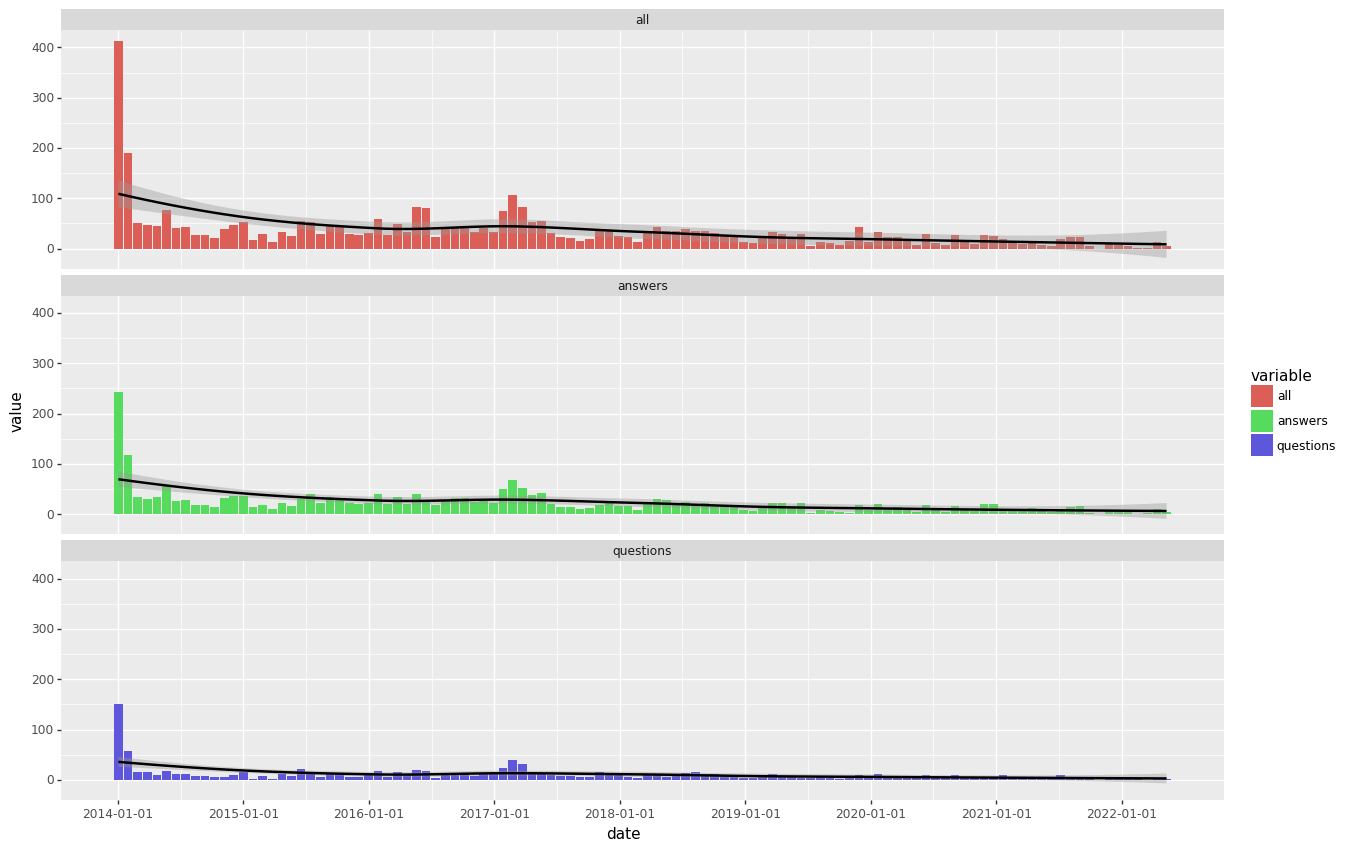

<ggplot: (8785994108971)>

In [7]:
from plotnine import aes, facet_wrap, ggplot, scale_x_datetime, options, stat_smooth, geom_col

options.figure_size = (15, 10)

posts_long = posts_grouped.melt(id_vars=('date'), value_vars=('all', 'questions', 'answers'))
posts_long.head()

(ggplot(posts_long, aes(x='date', y='value', group='variable'))
+ geom_col(aes(fill='variable')) 
+ scale_x_datetime()
+ stat_smooth(method='loess') 
+ facet_wrap('variable', ncol=1)
)


## Forum retention - time from account creation to last comments

In [8]:
users = spark.read.format('parquet').load("outputs/users").select(f.col('id'), f.col('creation_date'), f.col('display_name'))

In [9]:
users.show()

+---+--------------------+----------------+
| id|       creation_date|    display_name|
+---+--------------------+----------------+
| -1|2014-01-21 17:45:...|       Community|
|  1|2014-01-21 20:21:...|    Geoff Dalgas|
|  2|2014-01-21 20:22:...|  Kasra Rahjerdi|
|  3|2014-01-21 20:22:...|       Adam Lear|
|  4|2014-01-21 20:22:...|   Arie Litovsky|
|  5|2014-01-21 20:22:...|    Brian Nickel|
|  6|2014-01-21 20:23:...|        Jeremy T|
|  7|2014-01-21 20:24:...|      Tom Medley|
|  8|2014-01-21 20:25:...|LessPop_MoreFizz|
|  9|2014-01-21 20:25:...|     Nick Craver|
| 10|2014-01-21 20:28:...|          ChrisG|
| 11|2014-01-21 20:28:...|        hairboat|
| 12|2014-01-21 20:29:...|        nhaarman|
| 13|2014-01-21 20:29:...|           Shog9|
| 14|2014-01-21 20:32:...|     Ben Collins|
| 15|2014-01-21 20:33:...|             Ana|
| 16|2014-01-21 20:34:...|      Grace Note|
| 17|2014-01-21 20:34:...|     Jon Ericson|
| 18|2014-01-21 20:36:...|         awesame|
| 19|2014-01-21 20:36:...|   Ste

In [10]:
posts_by_user = posts.select(f.col('owner_user_id'), f.col('last_activity_date'), f.col('id').alias('post_id'))

In [11]:
posts_and_users_joined = (users
    .filter(f.col('id') != -1) # remove bots
    .join(posts_by_user, users.id  == posts_by_user.owner_user_id, how="left" )
    .filter(f.col('post_id').isNotNull()) # remove users that never posted
)

posts_and_users_joined.show()

+---+--------------------+--------------+-------------+--------------------+-------+
| id|       creation_date|  display_name|owner_user_id|  last_activity_date|post_id|
+---+--------------------+--------------+-------------+--------------------+-------+
|  2|2014-01-21 20:22:...|Kasra Rahjerdi|            2|2014-01-22 00:26:...|     39|
|  2|2014-01-21 20:22:...|Kasra Rahjerdi|            2|2014-01-22 05:50:...|     28|
|  4|2014-01-21 20:22:...| Arie Litovsky|            4|2016-03-06 04:31:...|     85|
|  5|2014-01-21 20:22:...|  Brian Nickel|            5|2014-02-04 23:20:...|    533|
|  5|2014-01-21 20:22:...|  Brian Nickel|            5|2014-01-23 16:41:...|    267|
|  5|2014-01-21 20:22:...|  Brian Nickel|            5|2014-01-22 18:36:...|    217|
|  5|2014-01-21 20:22:...|  Brian Nickel|            5|2018-08-09 15:38:...|     50|
|  5|2014-01-21 20:22:...|  Brian Nickel|            5|2014-01-21 20:59:...|     32|
|  5|2014-01-21 20:22:...|  Brian Nickel|            5|2014-01-21

In [12]:
posts_and_users_joined.select(f.col('post_id')).count() == posts_and_users_joined.select(f.col('post_id')).distinct().count()

True

In [13]:
user_last_post = (posts_and_users_joined
    .groupBy(f.col('id'), f.col('creation_date'))
    .agg(
        f.max(f.col('last_activity_date'))
    )
)

# time from account creation to last activity
user_last_post = user_last_post.withColumn('diff',f.datediff(f.col('max(last_activity_date)'), f.col('creation_date')) )
user_last_post.show()

+-----+--------------------+-----------------------+----+
|   id|       creation_date|max(last_activity_date)|diff|
+-----+--------------------+-----------------------+----+
| 6696|2017-04-27 18:46:...|   2017-09-18 21:40:...| 144|
| 7212|2017-10-24 01:20:...|   2017-10-24 01:20:...|   0|
| 7311|2017-11-28 23:29:...|   2017-12-23 14:32:...|  25|
|10039|2020-01-17 20:47:...|   2020-03-25 21:19:...|  68|
|  149|2014-01-22 16:41:...|   2014-01-23 08:52:...|   1|
|  736|2014-04-03 13:25:...|   2017-01-27 14:13:...|1030|
| 4197|2015-06-10 19:13:...|   2015-06-10 19:18:...|   0|
| 5654|2016-07-13 09:17:...|   2016-09-02 12:08:...|  51|
| 7154|2017-10-01 06:24:...|   2017-10-01 06:24:...|   0|
| 7286|2017-11-23 11:43:...|   2017-11-24 22:07:...|   1|
| 7936|2018-07-20 09:31:...|   2018-07-24 11:49:...|   4|
|11698|2020-11-12 20:24:...|   2020-11-12 20:24:...|   0|
| 1295|2014-09-10 17:56:...|   2016-10-08 14:17:...| 759|
| 5893|2016-09-11 03:06:...|   2016-09-11 03:07:...|   0|
| 6636|2017-04

In [14]:
user_last_post.select(f.col('id')).count() == user_last_post.select(f.col('id')).distinct().count()

True

/config/workspace/.venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
/config/workspace/.venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead


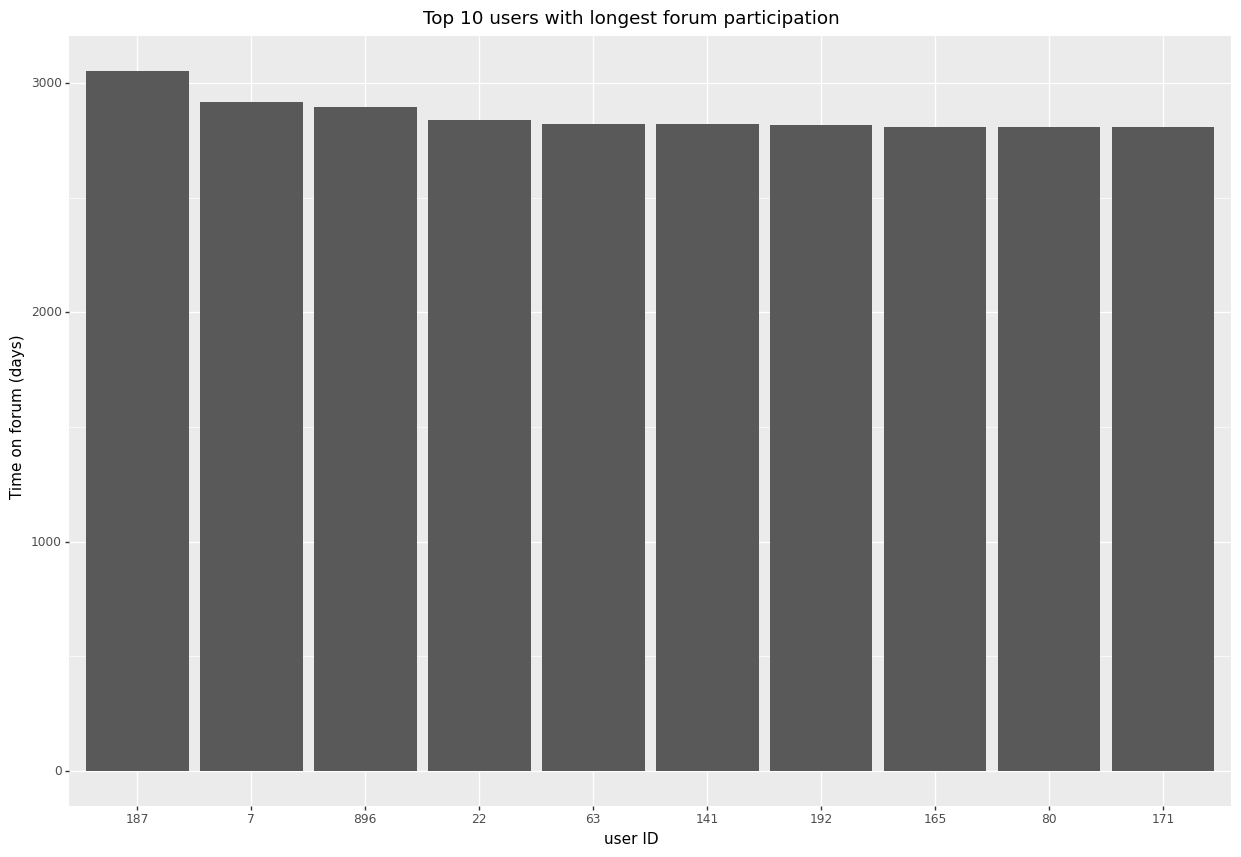

<ggplot: (8785942620109)>

In [15]:

user_last_post_df = user_last_post.orderBy(f.col('diff').desc()).limit(10).withColumn('id_cat', f.col('id').cast('string')).toPandas()

import pandas as pd
# add sorted categories for pretty plotting
user_last_post_df['id_cat'] = pd.Categorical(user_last_post_df.id_cat, categories=user_last_post_df.id_cat)

from plotnine import labs
(ggplot(user_last_post_df, aes(x='id_cat', y='diff'))
     + geom_col()
     + labs(x='user ID', y='Time on forum (days)', title='Top 10 users with longest forum participation')
)

## porównanie najwyżej i najniżej ocenianych pytań (długość, tagi, liczba odpowiedzi)

In [16]:
#users2 = spark.read.format('parquet').load("outputs/users").select(f.col('id'), f.col('creation_date'), f.col('display_name'))
#posts.show(1, vertical=True)




#1 - Question 2 - Answer 3 - Wiki 4 - TagWikiExcerpt 5 - TagWiki 6 - ModeratorNomination 7 -  WikiPlaceholder 8 - PrivilegeWiki
questions = posts.select(f.col('id'), f.col('body_clean'), f.col('answer_count'), f.col('view_count'), f.col('tags'), f.col('score'), f.col('post_type_id'))\
    .filter(f.col('post_type_id') == 1)\
    .drop(f.col('post_type_id'))

In [17]:
n_questions = 100
top_questions = questions.orderBy(f.col('score'), ascending=False).limit(n_questions).withColumn('type', f.lit('top'))
bottom_questions = questions.orderBy(f.col('score'), ascending=True).limit(n_questions).withColumn('type', f.lit('bottom'))
edge_questions = top_questions.unionAll(bottom_questions)

In [18]:
from pyspark.sql.functions import length
edge_questions = edge_questions.withColumn('post_len', f.length(f.col('body_clean')))
edge_questions_pd = edge_questions.toPandas()

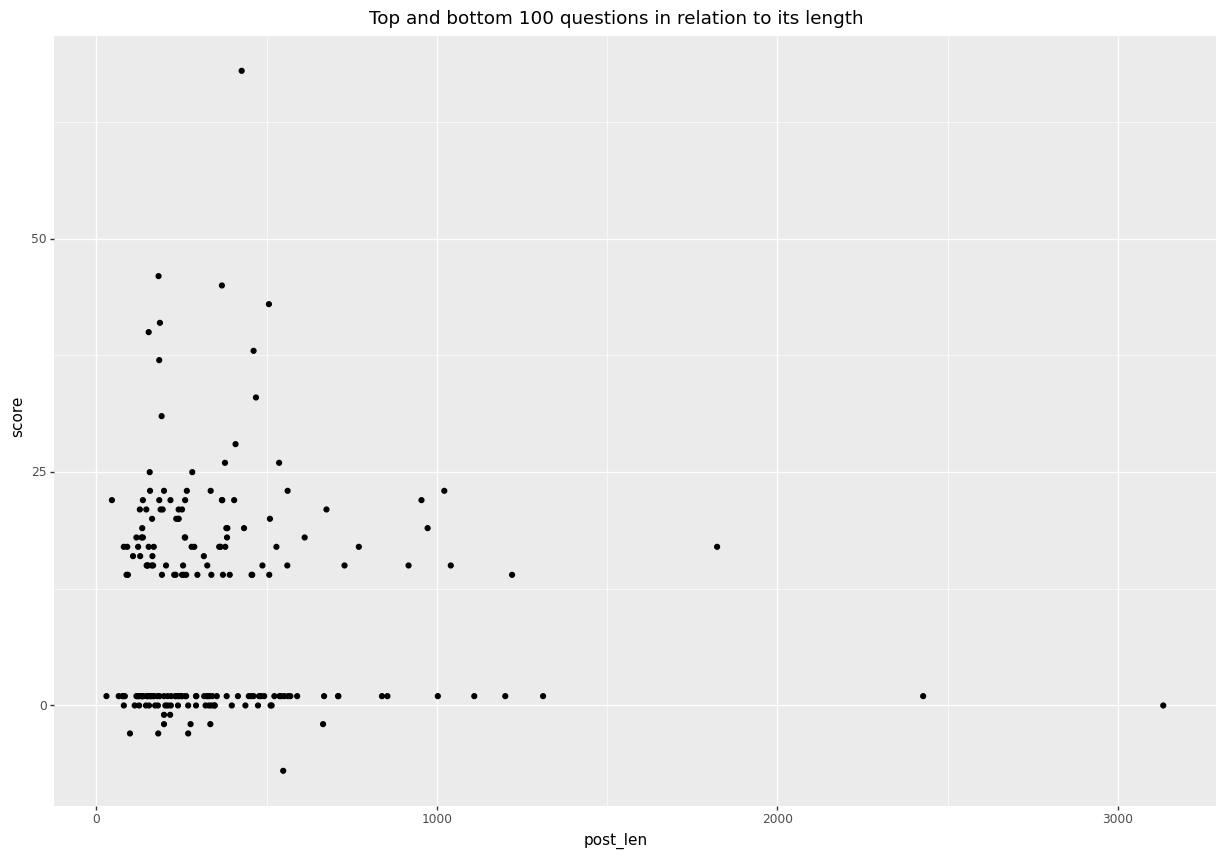

<ggplot: (8786045558433)>

In [19]:
from plotnine import ggplot, aes, geom_point, ggtitle

(ggplot(edge_questions_pd, aes(x = 'post_len', y = 'score') ) \
    + geom_point() \
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its length'))

In [20]:
edge_questions.groupby('type')\
    .agg(
        f.max(f.col('post_len')),
        f.min(f.col('post_len')),
        f.mean(f.col('post_len')),
        f.stddev(f.col('post_len')),
        f.percentile_approx(f.col('post_len'), 0.5)
    ).show()

+------+-------------+-------------+-------------+---------------------+---------------------------------------+
|  type|max(post_len)|min(post_len)|avg(post_len)|stddev_samp(post_len)|percentile_approx(post_len, 0.5, 10000)|
+------+-------------+-------------+-------------+---------------------+---------------------------------------+
|   top|         1823|           46|       349.08|   275.08858738430234|                                    261|
|bottom|         3133|           30|       389.26|   424.65483595146975|                                    270|
+------+-------------+-------------+-------------+---------------------+---------------------------------------+



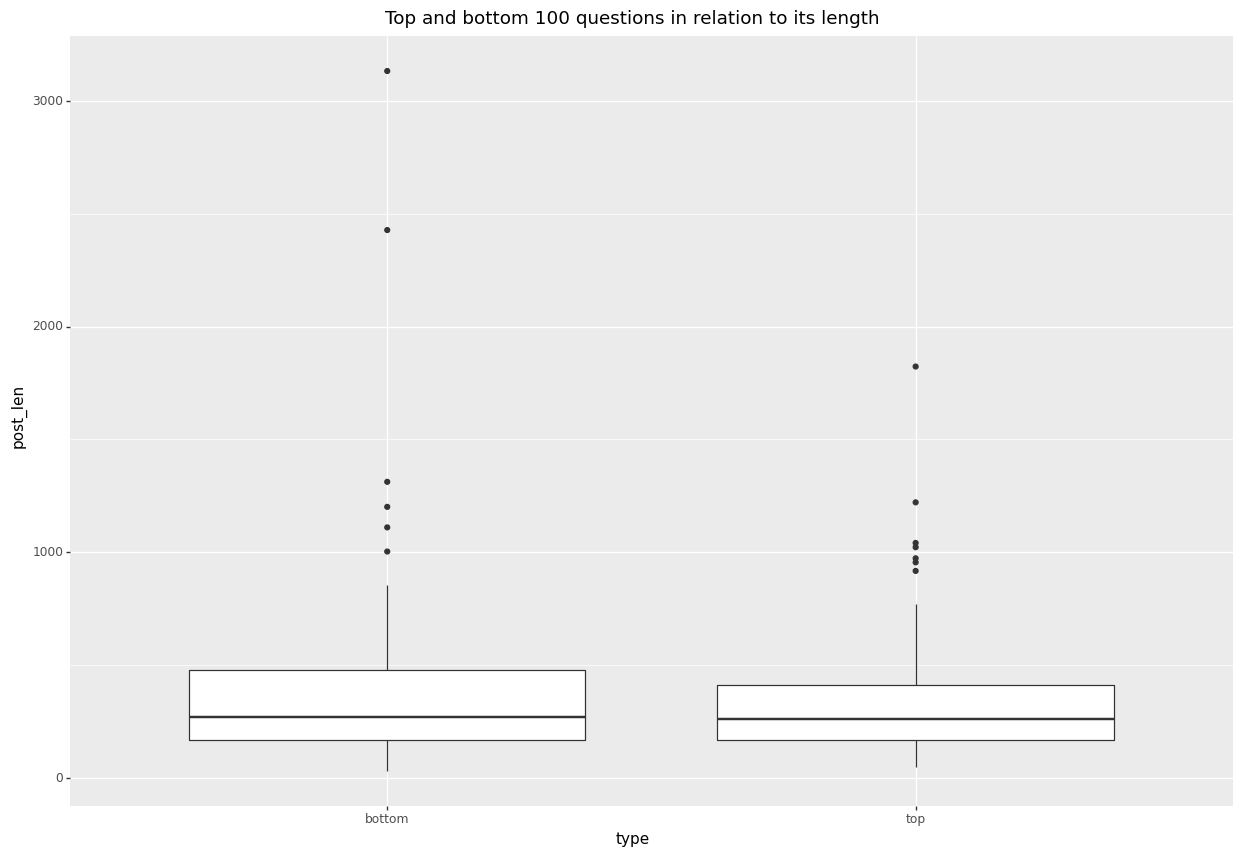

<ggplot: (8785942555621)>

In [21]:
from plotnine import ggplot, aes, geom_boxplot, ggtitle

(ggplot(edge_questions_pd, aes(x = 'type', y = 'post_len') ) \
    + geom_boxplot() \
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its length'))

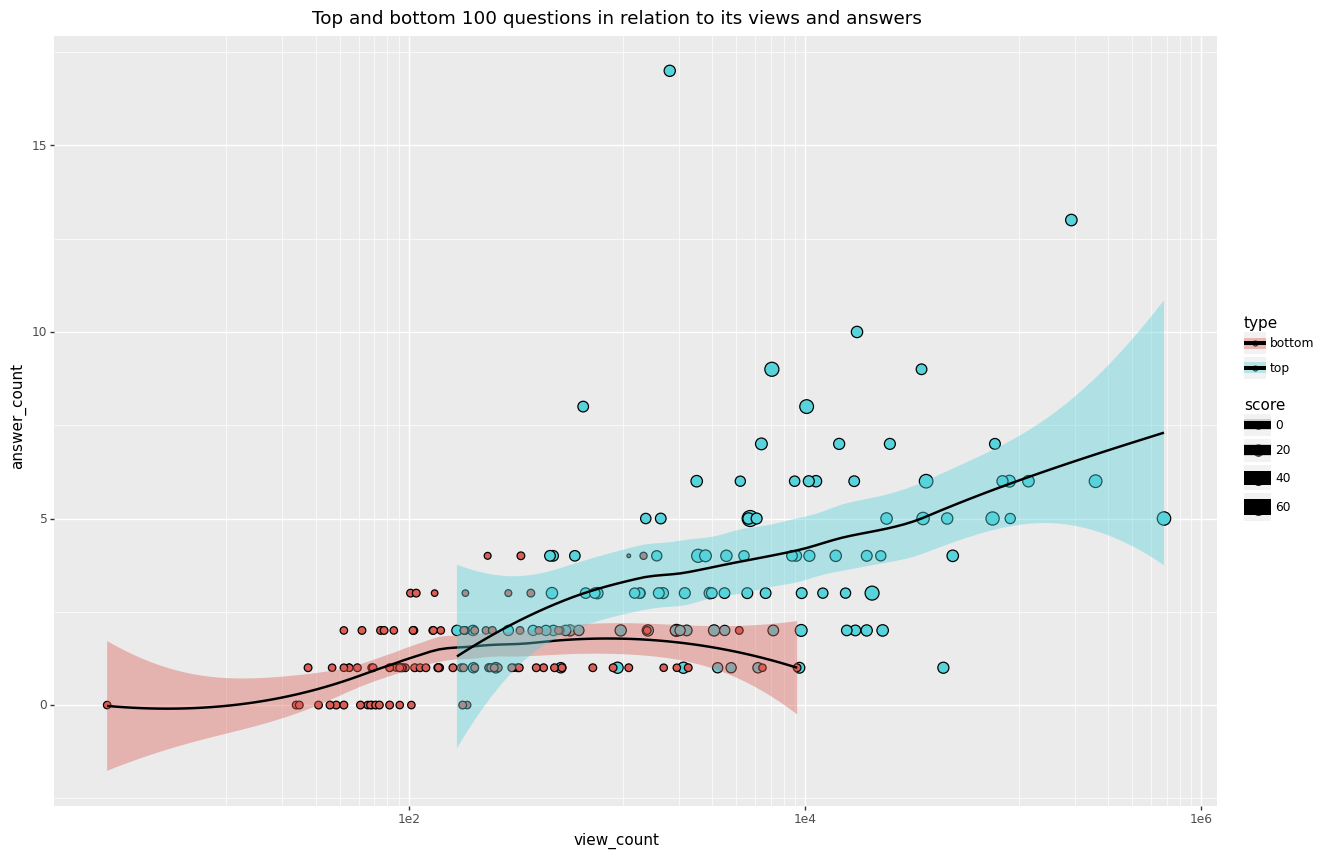

<ggplot: (8785942667757)>

In [22]:
from plotnine import ggplot, aes, geom_point, ggtitle, scale_x_log10, geom_smooth

(ggplot(edge_questions_pd, aes(x = 'view_count', y = 'answer_count', fill = 'type', size = 'score') ) \
    + geom_point() \
    + scale_x_log10()\
    + geom_smooth()\
    + ggtitle(f'Top and bottom {n_questions} questions in relation to its views and answers'))

In [23]:
edge_questions.groupby('type')\
    .agg(
        f.max(f.col('answer_count')),
        f.min(f.col('answer_count')),
        f.mean(f.col('answer_count')),
        f.stddev(f.col('answer_count')),
        f.percentile_approx(f.col('answer_count'), 0.5)
    ).show()

+------+-----------------+-----------------+-----------------+-------------------------+-------------------------------------------+
|  type|max(answer_count)|min(answer_count)|avg(answer_count)|stddev_samp(answer_count)|percentile_approx(answer_count, 0.5, 10000)|
+------+-----------------+-----------------+-----------------+-------------------------+-------------------------------------------+
|   top|               17|                1|             3.96|        2.581675910150324|                                          3|
|bottom|                4|                0|             1.28|       0.9648363026488436|                                          1|
+------+-----------------+-----------------+-----------------+-------------------------+-------------------------------------------+



In [24]:
edge_questions.groupby('type')\
    .agg(
        f.max(f.col('view_count')),
        f.min(f.col('view_count')),
        f.mean(f.col('view_count')),
        f.stddev(f.col('view_count')),
        f.percentile_approx(f.col('view_count'), 0.5)
    ).show()

+------+---------------+---------------+---------------+-----------------------+-----------------------------------------+
|  type|max(view_count)|min(view_count)|avg(view_count)|stddev_samp(view_count)|percentile_approx(view_count, 0.5, 10000)|
+------+---------------+---------------+---------------+-----------------------+-----------------------------------------+
|   top|         648941|            175|       26047.65|      76276.20019090576|                                     4715|
|bottom|           9124|              3|         495.56|     1220.7562924910794|                                      141|
+------+---------------+---------------+---------------+-----------------------+-----------------------------------------+



In [25]:
#https://gist.github.com/dannymeijer/be3534470b205280e52dbbcbb19a9670


from pyspark.sql import DataFrame
from pyspark.sql import functions as f


def regexp_extract_all(
    df: DataFrame,
    regex: str,
    no_of_extracts: int,
    input_column_name: str,
    output_column_name: str = "output",
    empty_array_replace: bool = True,
):
    """Pyspark implementation for extracting all matches of a reg_exp_extract
    
    Background
    ----------
    The regular implementation of regexp_extract (as part of pyspark.sql.functions module)
    is not capable of returning more than 1 match on a regexp string at a time. This 
    function can be used to circumvent this limitation.
    
    How it works
    ------------
    You can specify a `no_of_extracts` which will essentially run the regexp_extract 
    function that number of times on the `input_column` of the `df` (`DataFrame`). 
    In between extracts, a set of interim columns are created where every 
    intermediate match is stored. A distinct array is created from these matches, 
    after which the interim columns are dropped. The resulting array is stored in 
    the defined `output_column`. Empty strings/values in the resulting array can 
    optionally be dropped or kept depending on how `empty_array_replace` is set 
    (default is True).
    
    Usage example
    -------------
    In the below example, we are extracting all email-addresses from a body of text.
    The returned DataFrame will have a new ArrayType column added named `email_addresses`
    
    > # Assuming `df` is a valid DataFrame containing a column named `text`
    > email_regex = r"[\w.-]+@[\w.-]+\.[a-zA-Z]{1,}"
    > df = regexp_extract_all(df, email_regex, 6, "text", "email_addresses", True)
    
    Parameters
    ----------
    df: DataFrame
        Input DataFrame
    
    regex: str
        Regexp string to extract from input DataFrame
    
    no_of_extracts: int
        Max number of occurrences to extract
    
    input_column_name: str
        Name of the input column
    
    output_column_name: str
        Name of the output column (default: output)
    
    empty_array_replace: bool
        If set to True, will replace empty arrays with null values (default: True)
    """
    repeats = range(0, no_of_extracts)

    # A set of interim columns are created that will be dropped afterwards
    match_columns = [f"___{r}___" for r in repeats]

    # Apply regexp_extract an r number of times
    for r in repeats:
        df = df.withColumn(
            match_columns[r],
            f.regexp_extract(
                f.col(input_column_name),
                # the input regex string is amended with ".*?"
                # and repeated an r number of times
                # r needs to be +1 as matching groups are 1-indexed
                "".join([f"{regex}.*?" for i in range(0, r + 1)]),
                r + 1,
            ),
        )

    # Create a distinct array with all empty strings removed
    df = df.withColumn(
        output_column_name,
        f.array_remove(f.array_distinct(f.array(match_columns)), ""),
    )

    # Replace empty string with None if empty_array_replace was set
    if empty_array_replace:
        df = df.withColumn(
            output_column_name,
            f.when(f.size(output_column_name) == 0, f.lit(None)).otherwise(
                f.col(output_column_name)
            ),
        )

    # Drop interim columns
    for c in match_columns:
        df = df.drop(c)

    return df

In [26]:
#edge_questions.select(f.col('tags')).withColumn('tags_split', f.regexp_extract(f.col('tags'), r'<(\w+)>')).show()

edge_questions = regexp_extract_all(edge_questions, r'<(\w+)>', 99, "tags", "tags_split", True)

In [27]:
import pyspark.rdd as rdd
h = edge_questions.filter(f.col('type') == 'top').select(f.col('tags_split')).rdd
l = edge_questions.filter(f.col('type') == 'bottom').select(f.col('tags_split')).rdd

In [28]:
h.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])\
    .map(lambda x: (x, 1))\
    .aggregateByKey(0, (lambda acc,x: acc + x ), (lambda acc1,acc2: acc1+acc2))\
    .filter(lambda x: x[1] > 1)\
    .sortBy(lambda x: x[1], ascending=False)\
    .collect()

[('taste', 17),
 ('brewing', 14),
 ('history', 12),
 ('glassware', 8),
 ('storage', 8),
 ('serving', 8),
 ('style', 8),
 ('temperature', 6),
 ('stout', 5),
 ('terminology', 5),
 ('aging', 4),
 ('health', 4),
 ('bottles', 4),
 ('ingredients', 4),
 ('breweries', 3),
 ('ipa', 3),
 ('classification', 3),
 ('whiskey', 3),
 ('tripel', 3),
 ('drinking', 3),
 ('bottling', 3),
 ('flavor', 3),
 ('colour', 3),
 ('aroma', 2),
 ('freshness', 2),
 ('ale', 2),
 ('lager', 2),
 ('preservation', 2),
 ('foam', 2),
 ('dubbel', 2),
 ('skunking', 2),
 ('laws', 2),
 ('draught', 2),
 ('pouring', 2),
 ('pairing', 2),
 ('keg', 2),
 ('water', 2),
 ('trappist', 2),
 ('carbonation', 2)]

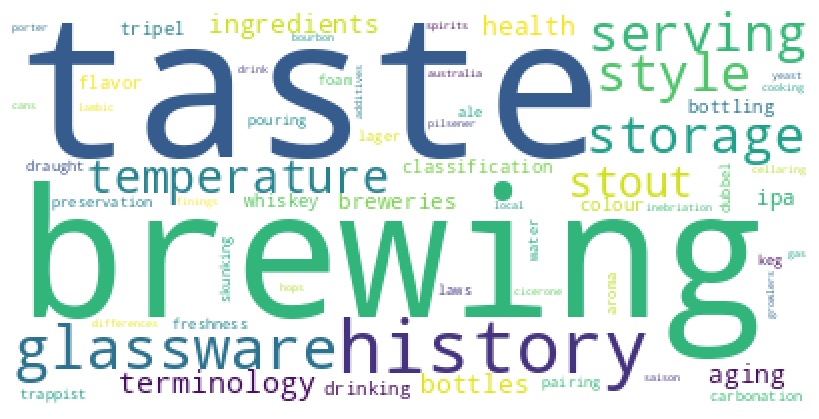

In [29]:
tags_rdd = h.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])

x = tags_rdd.collect()
tags_str = ''
for y in range(len(x)):
    tags_str += f"{x[y]} "

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color ='white').generate(tags_str)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

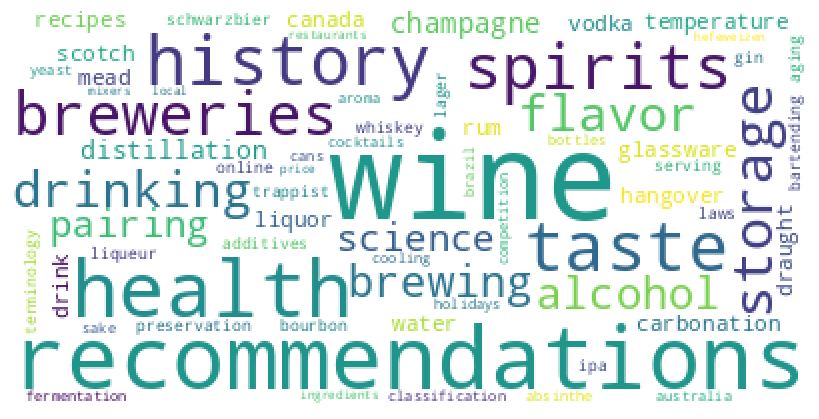

In [30]:
tags_rdd = l.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])

x = tags_rdd.collect()
tags_str = ''
for y in range(len(x)):
    tags_str += f"{x[y]} "

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud(background_color ='white').generate(tags_str)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wc)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [31]:
l.flatMap(lambda x: [y if y is not None else "" for y in x])\
    .flatMap(lambda x: [x[y] for y in range(0, len(x))])\
    .map(lambda x: (x, 1))\
    .aggregateByKey(0, (lambda acc,x: acc + x ), (lambda acc1,acc2: acc1+acc2))\
    .filter(lambda x: x[1] > 1)\
    .sortBy(lambda x: x[1], ascending=False)\
    .collect()

[('wine', 20),
 ('recommendations', 14),
 ('health', 11),
 ('taste', 8),
 ('history', 8),
 ('spirits', 7),
 ('breweries', 6),
 ('storage', 5),
 ('drinking', 4),
 ('flavor', 4),
 ('brewing', 4),
 ('alcohol', 4),
 ('pairing', 3),
 ('science', 3),
 ('champagne', 3),
 ('distillation', 3),
 ('temperature', 2),
 ('glassware', 2),
 ('scotch', 2),
 ('hangover', 2),
 ('water', 2),
 ('rum', 2),
 ('liquor', 2),
 ('draught', 2),
 ('vodka', 2),
 ('mead', 2),
 ('carbonation', 2),
 ('canada', 2),
 ('drink', 2),
 ('recipes', 2)]

## procent przypadków kiedy najwyżej oceniana odpowiedź to nie zaakceptowana odpowiedź

In [32]:
#1 - Question 2 - Answer 3 - Wiki 4 - TagWikiExcerpt 5 - TagWiki 6 - ModeratorNomination 7 -  WikiPlaceholder 8 - PrivilegeWiki
posts_tmp = posts.select(f.col('id'), f.col("parent_id"), f.col('accepted_answer_id'), f.col('answer_count'), f.col('score'), f.col('post_type_id'))
questions = posts_tmp.filter('post_type_id == 1 and answer_count > 0')\
    .select(f.col('id').alias('q_id'), f.col('accepted_answer_id'))

answers = posts_tmp.filter(f.col('post_type_id') == 2)\
    .select(f.col('id').alias('a_id'), f.col('parent_id'), f.col('score'))

In [33]:
from pyspark.sql import Window

window_partition_agg = Window.partitionBy("q_id")

questions.join(answers, on=questions.q_id == answers.parent_id)\
    .sort(['q_id', 'a_id'])\
    .withColumn("max_score", f.max(f.col("score")).over(window_partition_agg))\
    .filter(f.col("score") == f.col("max_score"))\
    .filter(f.col("accepted_answer_id").isNotNull())\
    .withColumn("is_accepted_best", f.col("accepted_answer_id") == f.col("a_id"))\
    .agg(
        f.sum(f.col("is_accepted_best").cast("integer")).alias("sum"),
        f.count(f.col("q_id")).alias("count")
    )\
    .withColumn("percent", (f.col("count") - f.col("sum")) / f.col("count") * 100).show()

+---+-----+------------------+
|sum|count|           percent|
+---+-----+------------------+
|641|  735|12.789115646258503|
+---+-----+------------------+



## rozkład ocen odpowiedzi zaakceptowanych vs pozostałych (średnia, odchylenie, minimum, maksimum)

In [34]:
window_partition_agg = Window.partitionBy("q_id")

questions.join(answers, on=questions.q_id == answers.parent_id)\
    .sort(['q_id', 'a_id'])\
    .withColumn("is_accepted", f.col("accepted_answer_id") == f.col("a_id"))\
    .groupBy(f.col("is_accepted")).agg(
        f.avg(f.col("score")).alias("avg_score"),
        f.stddev(f.col("score")).alias("std_score"),
        f.min(f.col("score")).alias("min_score"),
        f.max(f.col("score")).alias("max_score"),
        f.count("a_id")
    ).show()

+-----------+------------------+------------------+---------+---------+-----------+
|is_accepted|         avg_score|         std_score|min_score|max_score|count(a_id)|
+-----------+------------------+------------------+---------+---------+-----------+
|       null|2.7551686615886832|3.1818372333580007|       -5|       30|        919|
|       true| 6.395043731778426| 5.915949387154137|        0|       46|        686|
|      false|2.5841694537346713|2.7353292123298076|       -4|       26|        897|
+-----------+------------------+------------------+---------+---------+-----------+



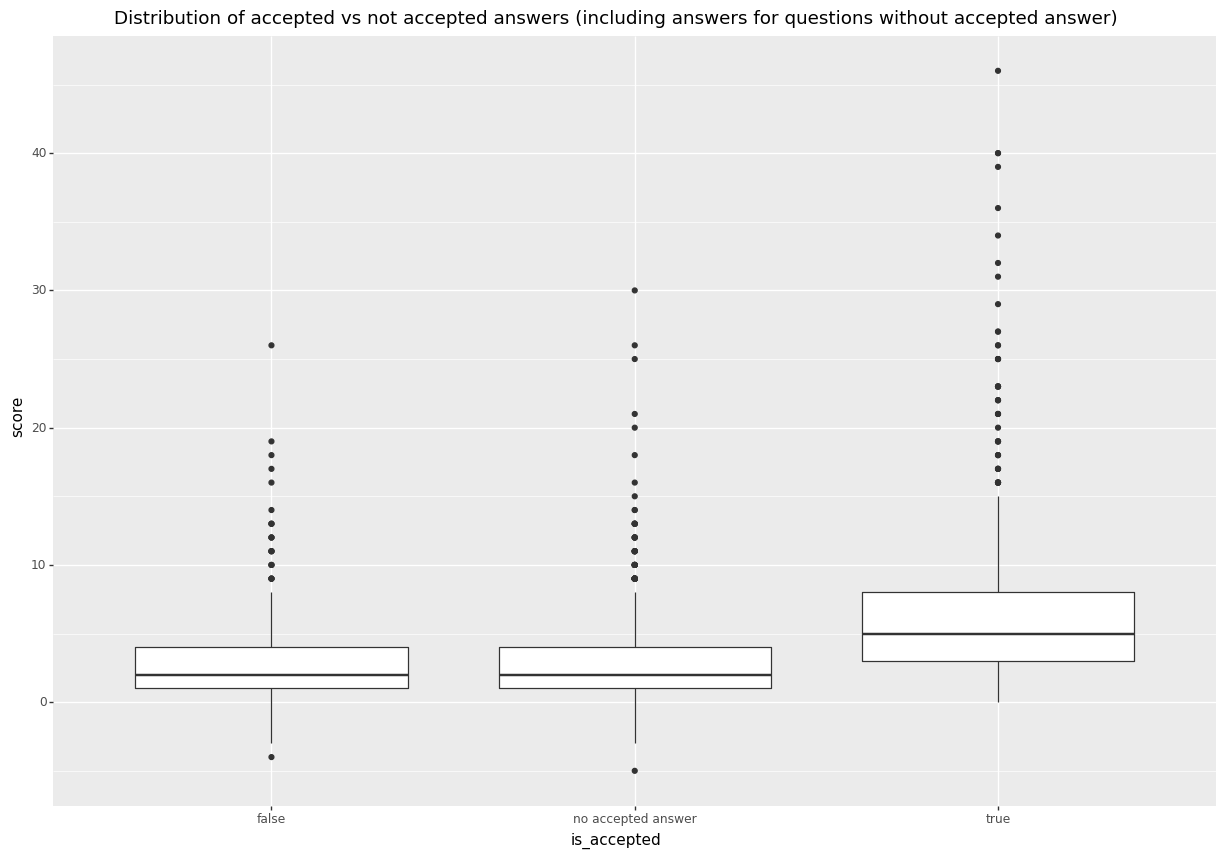

<ggplot: (8785942528877)>

In [35]:
accepted_df = questions.join(answers, on=questions.q_id == answers.parent_id)\
    .sort(['q_id', 'a_id'])\
    .withColumn("is_accepted", (f.col("accepted_answer_id") == f.col("a_id")).cast("string"))\
    .withColumn("is_accepted", f.when(f.col("is_accepted").isNull(), "no accepted answer").otherwise(f.col("is_accepted"))).toPandas()

(ggplot(accepted_df, aes(x="is_accepted", y="score"))\
    +geom_boxplot()\
    +ggtitle("Distribution of accepted vs not accepted answers (including answers for questions without accepted answer)"))

## top N tagów które wygenerowały najwięcej wyświetleń

In [45]:
tags_views = posts.select(['tags', 'view_count'])
tags_views_agg = regexp_extract_all(tags_views, r'<(\w+)>', 99, "tags", "tags_split", True)\
    .select([f.explode(f.col('tags_split')).alias("tag"), f.col("view_count")])\
    .filter(f.col("view_count").isNotNull())\
    .groupBy('tag')\
    .agg(
        f.sum("view_count").alias("sum_views")
    )

In [46]:
#| include: false
tag_top_views = tags_views_agg.orderBy("sum_views", ascending=False).limit(20).toPandas()

23/01/14 19:50:32 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "hashAgg_doAggregateWithKeys_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage1;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "hashAgg_doAggregateWithKeys_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage1;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	

In [49]:
tag_top_views.head(20)

,tag,sum_views
0,taste,1330670
1,health,1286001
2,preservation,682216
3,storage,542860
4,whiskey,464756
5,bourbon,330268
6,brewing,307892
7,ipa,291935
8,spirits,255328
9,drinking,225924


## liczba postów w czasie dla każdego z top N tagów (lineplot/barplot)

In [39]:
#1 - Question 2 - Answer 3 - Wiki 4 - TagWikiExcerpt 5 - TagWiki 6 - ModeratorNomination 7 -  WikiPlaceholder 8 - PrivilegeWiki
posts_tmp = posts.select(f.col('id'), f.col('creation_date'), f.col('tags'))

posts_tags_time = regexp_extract_all(posts_tmp, r'<(\w+)>', 99, "tags", "tags_split", True).withColumn('tag', f.explode(f.col('tags_split'))).filter(f.col("tag").isNotNull())

top_posts_tags_time = posts_tags_time.join(tag_top_views, on="tag", how="inner").select(f.col('id'), f.col('tag'), f.col('creation_date')).distinct()

In [ ]:
#| include: false

from plotnine import geom_bar, ylim

top_posts_tags_time_agg = top_posts_tags_time.groupBy(
        f.window('creation_date', '4 weeks'), f.col("tag")
    ) \
    .agg(
        f.sum(f.lit(1)).alias('count')
    )\
    .withColumn('date', f.col('window.start').cast('date'))

top_posts_tags_time_agg_pd = top_posts_tags_time_agg.toPandas()



In [ ]:
(ggplot(top_posts_tags_time_agg_pd, aes("date", "count"))\
    + scale_x_datetime()\
    + geom_col() \
    + facet_wrap("tag", ncol=3) \
    + ylim(0, 15))

## najczęściej pojawiające się słowa w tytułach (z pominięciem stopwords

In [41]:
from bs4 import BeautifulSoup
from html import unescape
from pyspark.sql.functions import udf, regexp_replace
from pyspark.sql.types import *
# remove html tags
def tags_remove(s):
    soup = BeautifulSoup(unescape(s), 'lxml')
    return soup.text

udf_tags_remove = udf(lambda m: tags_remove(m))

titles = posts.filter(f.col("title").isNotNull()).select(f.col("title"))\
    .withColumn("title_clean", f.lower(f.col("title")))\
    .withColumn("title_clean", regexp_replace('title_clean', "[^a-zA-Z\\s]", " "))

from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
udf_filter_length = udf(lambda row: [x for x in row if len(x) > 1], ArrayType(StringType()))

stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda token: stemmer.stem(token), StringType())

tokenizer = Tokenizer(inputCol='title_clean', outputCol='words_token')
title_tokens = tokenizer.transform(titles).withColumn('words_token', udf_filter_length(f.col('words_token')))





remover = StopWordsRemover(inputCol='words_token', outputCol='words_no_stop')
title_tokens_no_stop = remover.transform(title_tokens)
exploded = title_tokens_no_stop.withColumn("words", f.explode(f.col("words_no_stop")))

title_stem = exploded.withColumn('words_stem', stemmer_udf("words"))

word_lookup = title_stem.select([f.col("words"), f.col("words_stem")]).distinct()
word_lookup.show() # TODO aggregate this
title_stem.groupBy("words_stem").agg(f.count("title").alias('count')).orderBy('count', ascending=False).show()

+---------------+-----------+
|          words| words_stem|
+---------------+-----------+
|         opened|       open|
|antidepressants|antidepress|
|          taken|      taken|
|    alternative|     altern|
|       learning|      learn|
|         sherry|     sherri|
|      regionali|  regionali|
|      archetype|   archetyp|
|      inhibitor|  inhibitor|
|        outside|     outsid|
|            bay|        bay|
|        sangria|    sangria|
|         invest|     invest|
|        togther|    togther|
|           fake|       fake|
|         kahlua|     kahlua|
|       imported|     import|
|         tables|       tabl|
|         desire|      desir|
|        bavaria|    bavaria|
+---------------+-----------+
only showing top 20 rows

+----------+-----+
|words_stem|count|
+----------+-----+
|      beer|  476|
|      wine|  147|
|     drink|  104|
|   alcohol|   88|
|    differ|   72|
|     bottl|   68|
|       use|   50|
|      tast|   47|
|      brew|   43|
|      make|   41|
|      

## procent użytkowników którzy nigdy nic nie zapostowali

In [42]:
# users.show(2)
# posts.show(2)

users_posts = (users.join(
    (posts.select(f.col('id').alias('post_id'), f.col('owner_user_id'))), on=[users.id == posts.owner_user_id], how="full")\
    .filter("id IS NOT NULL and NOT id = -1")
    )

users_posts.select([f.col('id'), f.col('post_id')])\
    .groupBy("id")\
        .agg(
            f.count(f.col('post_id')).alias('post_count')
        )\
    .agg(
        f.sum(f.when(f.col('post_count') == 0, f.lit(1)).otherwise(f.lit(0))).alias("not_posted"),
        f.count('id').alias('all')
    ) \
    .withColumn('% not posted', (f.col("not_posted") / f.col('all') * 100)).show()

# (users.join(
#     (posts.select(f.col('id').alias('post_id'), f.col('owner_user_id'))), on=[users.id == posts.owner_user_id], how="full")\
#     .filter(f.col('id').isNotNull() & f.col('post_id').isNull())\
#     .select([f.col('id'), f.col('display_name')]).distinct()\
#     .show()
#     )

+----------+----+-----------------+
|not_posted| all|     % not posted|
+----------+----+-----------------+
|      7691|8947|85.96177489661339|
+----------+----+-----------------+



## średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi

+-----------------------+-------------------------------+------------------------+
|avg(time_to_accept_min)|stddev_samp(time_to_accept_min)|quantiles               |
+-----------------------+-------------------------------+------------------------+
|25244.9435714286       |123338.6325101642              |[141.53, 753.25, 3605.8]|
+-----------------------+-------------------------------+------------------------+



/config/workspace/.venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
/config/workspace/.venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead


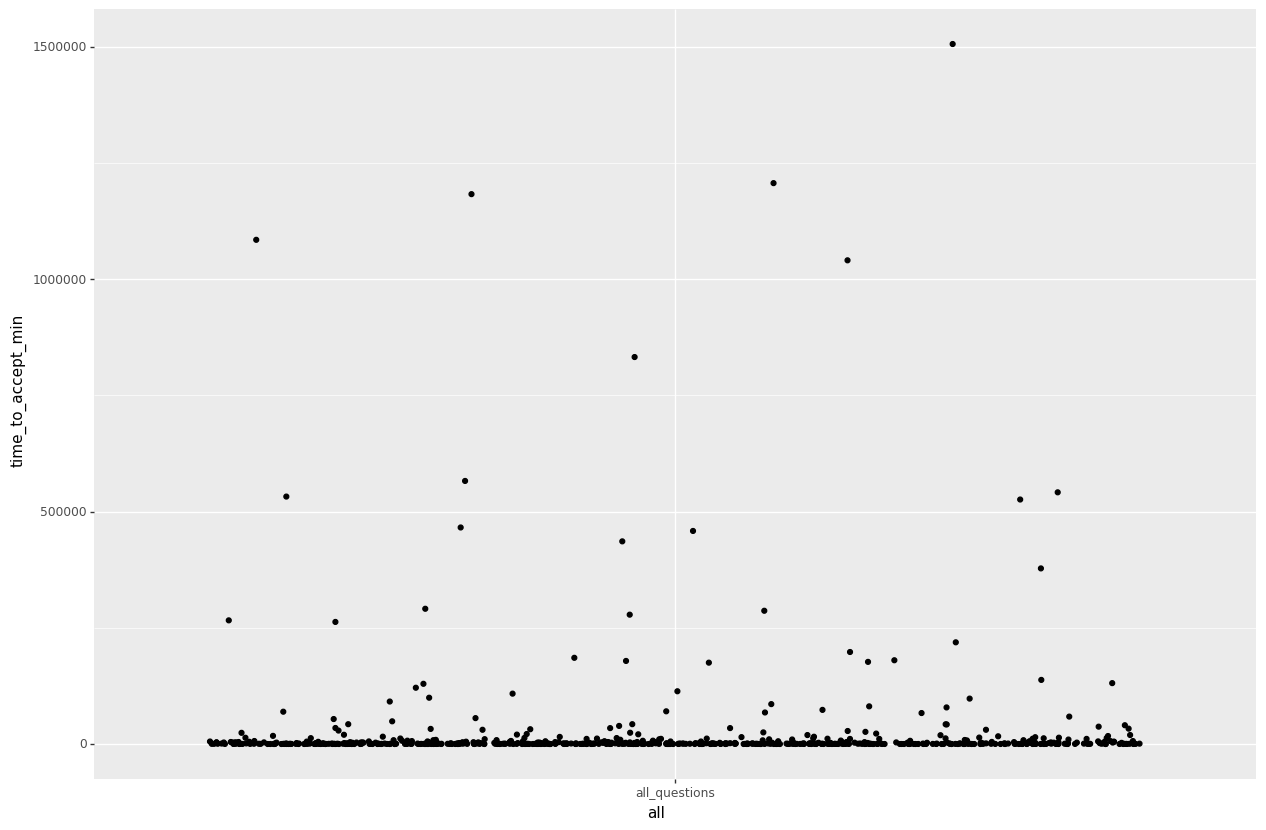

<ggplot: (8785939115177)>

In [43]:
# keep only questions with answers
questions = posts.filter(f.col('post_type_id') == 1).filter(f.col('answer_count') > 0).select([f.col('id').alias('q_id'), f.col('creation_date').alias('q_creation_date'), f.col('accepted_answer_id')])
answers  = posts.filter(f.col('post_type_id') == 2).select([f.col('id').alias('a_id'), f.col('parent_id').alias('a_parent_id'), f.col('creation_date').alias('a_creation_date')])
#posts.show(1, vertical=True)
time_to_accept = questions.join(answers, on=[questions.accepted_answer_id==answers.a_id])\
    .withColumn('time_to_accept_sec', f.unix_timestamp('a_creation_date') - f.unix_timestamp('q_creation_date'))\
    .withColumn('time_to_accept_min', f.round(f.col('time_to_accept_sec') / 60, 2))

time_to_accept.agg(
        f.avg('time_to_accept_min'),
        f.stddev('time_to_accept_min'),
        f.percentile_approx("time_to_accept_min", [0.25, 0.5, 0.75], 1000000).alias("quantiles")
    ).show(truncate=False)


time_to_accept_pd = time_to_accept.withColumn('all', f.lit("all_questions")).toPandas()

from plotnine import geom_jitter
(ggplot(time_to_accept_pd, aes(x='all', y="time_to_accept_min"))\
    +geom_jitter())

### remove outliers

+-----------------------+-------------------------------+-------------------------+
|avg(time_to_accept_min)|stddev_samp(time_to_accept_min)|quantiles                |
+-----------------------+-------------------------------+-------------------------+
|4769.308792048925      |12694.627623679486             |[127.72, 644.93, 2922.82]|
+-----------------------+-------------------------------+-------------------------+



/config/workspace/.venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
/config/workspace/.venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead


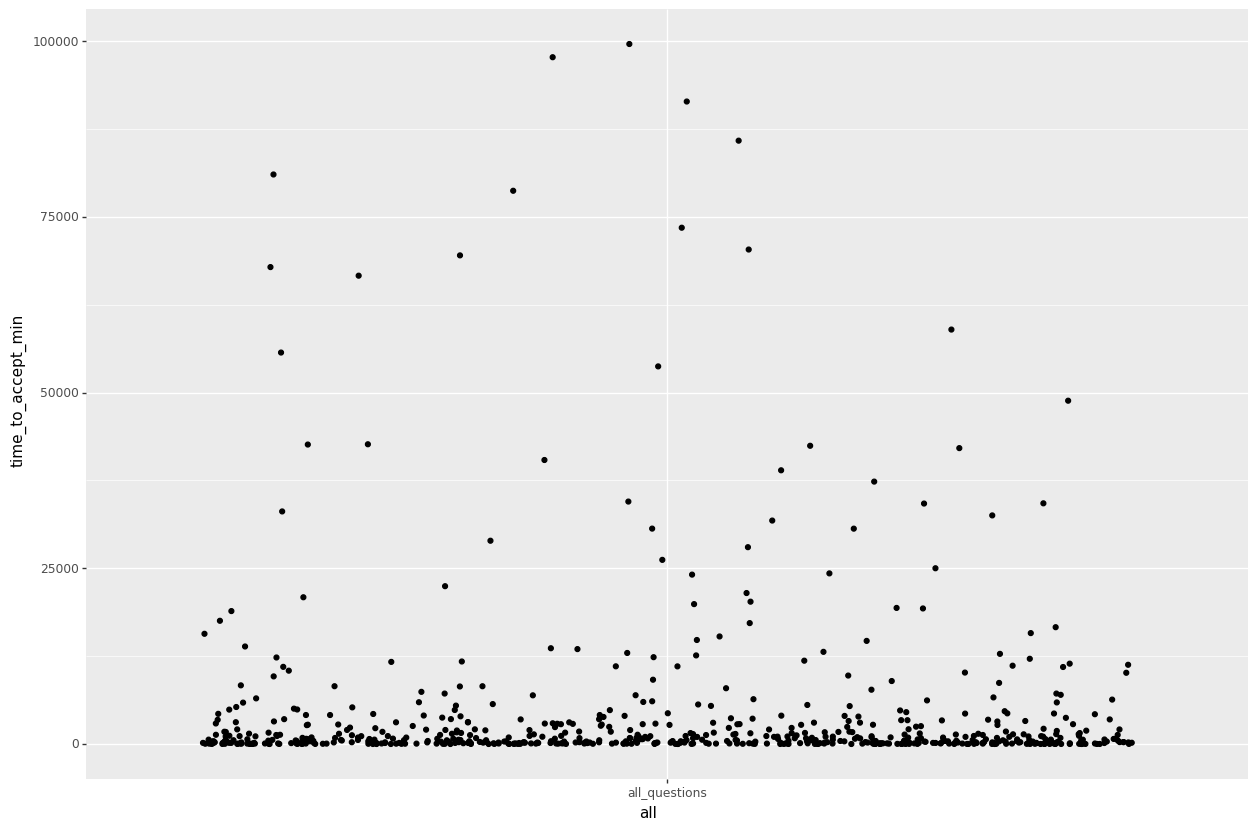

<ggplot: (8785939033767)>

In [44]:
no_outliers = time_to_accept.filter(f.col('time_to_accept_min') < 100000)

no_outliers.agg(
        f.avg('time_to_accept_min'),
        f.stddev('time_to_accept_min'),
        f.percentile_approx("time_to_accept_min", [0.25, 0.5, 0.75], 1000000).alias("quantiles")
    ).show(truncate=False)

no_outliers_pd = no_outliers.withColumn('all', f.lit("all_questions")).toPandas()
(ggplot(no_outliers_pd, aes(x='all', y="time_to_accept_min"))\
    +geom_jitter())